#### in this notebook i follow and try to explain more how to trian and test FCN network for semantic segmentation , adobted from this great blog post 
https://fairyonice.github.io/Learn-about-Fully-Convolutional-Networks-for-semantic-segmentation.html?fbclid=IwAR1ZTgEsIWm60hHZwMeSOpfQW7L1iyRz5Necg-3Z5_0bmXVyrZXTuqrNXrM#Fully-convosutional-network

In [1]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dir_data = "dataset/"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"

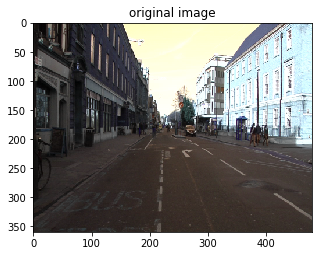

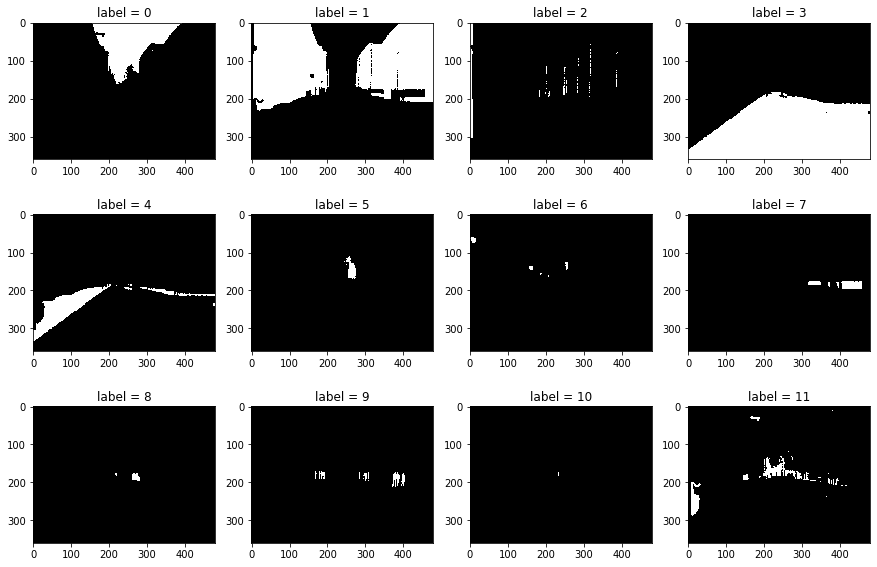

In [3]:
ldseg = os.listdir(dir_seg)
ldimgs = os.listdir(dir_img)
## test the first image file
label1 = ldseg[0]
image1=ldimgs[0]
seg=cv2.imread(dir_seg+label1)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(cv2.imread(dir_img+image1))
ax.set_title("original image")
plt.show()
fig = plt.figure(figsize=(15,10))
for k in range(12):
    ax = fig.add_subplot(3,12/3,k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))
plt.show()

## Images / Labels Visualizations

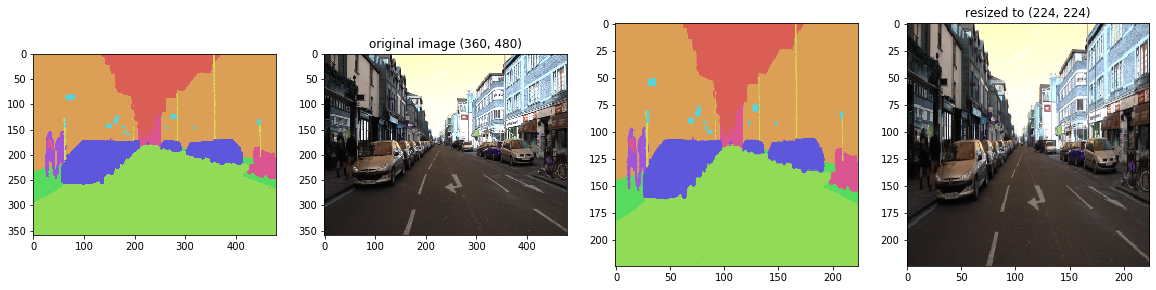

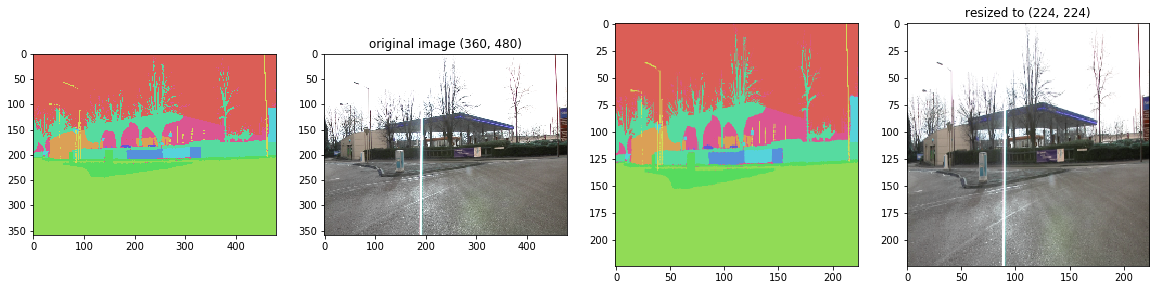

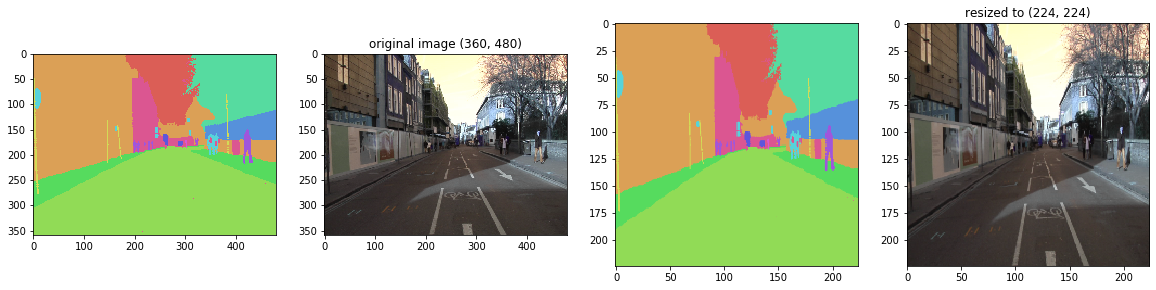

In [4]:
import random
def give_color_to_seg_img(seg,n_classes):
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

input_height , input_width = 224 , 224
output_height , output_width = 224 , 224

n_classes=12
ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),3,replace=False)]:
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg + fnm + ".png") # (360, 480, 3)
    img_is = cv2.imread(dir_img + fnm + ".png")
    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height , input_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()

## Data preprocessing

In [5]:
def getImageArr( path , width , height ):
    '''
    path : image path
    width : desired width
    height : desired height
    return : image with new size
    '''
    img = cv2.imread(path)
    img = cv2.resize(img, ( width , height ),interpolation=cv2.INTER_AREA)/255.0 # image scalling
    return img

def getSegmentationArr( path , nClasses ,  width , height  ):
    '''
    path :image path
    nclasses:number of classes in the image
    width : desired width
    height : desired height
    return : label tensor of shape (width,height,nClasses) where every channel corresponds into class label 
    '''
    seg_labels = np.zeros(shape=(width,height,nClasses))
    img = cv2.imread(path)
    img = cv2.resize(img, ( width , height ),interpolation=cv2.INTER_AREA) # cv2.INTER_AREA for image shrinking
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    return seg_labels


images = os.listdir(dir_img)
segmentations  = os.listdir(dir_seg)
images.sort()
segmentations.sort()
input_height , input_width = 224 , 224
output_height , output_width = 224 , 224

n_classes=12
    
X = []
Y = []
for im , seg in zip(images,segmentations) :
    X.append( getImageArr(dir_img + im , input_width , input_height )  )
    Y.append( getSegmentationArr( dir_seg + seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
print(X.shape,Y.shape)

(367, 224, 224, 3) (367, 224, 224, 12)


## FCN ntework

- Orinary CNNs may be not good at solving semantic segmentation problem , because of fully connected layers descretizes the pixel space but we want it to be continious , so FCN authors proposed "fully connected layers can also be viewed as convolutions with kernels that cover their entire input regions. Doing so casts them into fully convolutional networks that take input of any size and output classification maps"
- The model I used in this blog post is FCN8 from Fully Convolutional Networks for Semantic Segmentation. It deplicates VGG16 net by discarding the final classifier layer and convert all fully connected layers to convolutions. Fully Convolutional Networks for Semantic Segmentation appends a 1 x 1 convolution with channel dimension the same as the number of segmentation classes (in our case, this is 12) to predict scores at each of the coarse output locations, followed by upsampling deconvolution layers which brings back low resolution image to the output image size. In our example, output image size is (output_height, output_width) = (224,224)


## Network Architecture

In [8]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
import pandas as pd 

VGG_Weights_path = "VGG16_weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

def FCN8( nClasses ,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    # VGG16 architecture 
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    vgg  = Model(  img_input , pool5  )
    vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    # treating fully connected layers as 1 by 1 convolution
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
    
    # upsampling / decoding process
    
    ## 4 times upsampling for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

model = FCN8(nClasses     = 12,  
             input_height = 224, 
             input_width  = 224)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [9]:
from sklearn.utils import shuffle
train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(311, 224, 224, 3) (311, 224, 224, 12)
(56, 224, 224, 3) (56, 224, 224, 12)


## Model Training

In [ ]:
from keras import optimizers


sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

hist1 = model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  batch_size=32,epochs=200,verbose=2)

In [ ]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()